← Reusing cached SpatialData.
← Reusing cached H&E image and pixel sizes.
[DEBUG] Starting patch extraction pipeline

← Using provided SpatialData and H&E image, skipping load_data.
→ Filtering cells based on total counts using MAD …
→ Applying MAD-based filtering on total_counts
✔ 449697 cells kept (≥ 61.0 total_counts)
✔ 449697 cells kept (≥ 61.0 transcripts)
→ Extracting centroids from SpatialData geometry …
[DEBUG] Entering extract_xenium_nucleus_centroids_from_spatialdata
[DEBUG] Available shape keys: ['cell_boundaries', 'cell_circles', 'nucleus_boundaries']
[DEBUG] Using 'nucleus_boundaries' from sdata.shapes
[DEBUG] nucleus_shapes contains 574852 geometries


/var/folders/c0/44p3b4xx4v956042lj_vp7z80000gn/T/ipykernel_66600/60167233.py:258: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  cell_table = sdata.table if hasattr(sdata, 'table') else sdata['table']


[DEBUG] Extracted 574852 nucleus centroids
[DEBUG] Exiting extract_xenium_nucleus_centroids_from_spatialdata
→ Debug: First few valid_cell_ids: ['0' '3' '4']
→ Debug: First few all_cell_ids: [1 2 3]
→ Debug: Types - valid_cell_ids: <class 'str'>, all_cell_ids: <class 'numpy.int32'>
✔ Extracted 449696 valid centroids after MAD filtering

→ Converting centroids from µm → pixels …
✔ Sample pixel coords: [[ 3966 48880]
 [ 3980 48899]
 [ 3900 48916]
 [ 3872 48923]
 [ 3938 50360]] 

→ Sampled 303 cells

→ Fast downsample to (5373, 4837) via slicing …


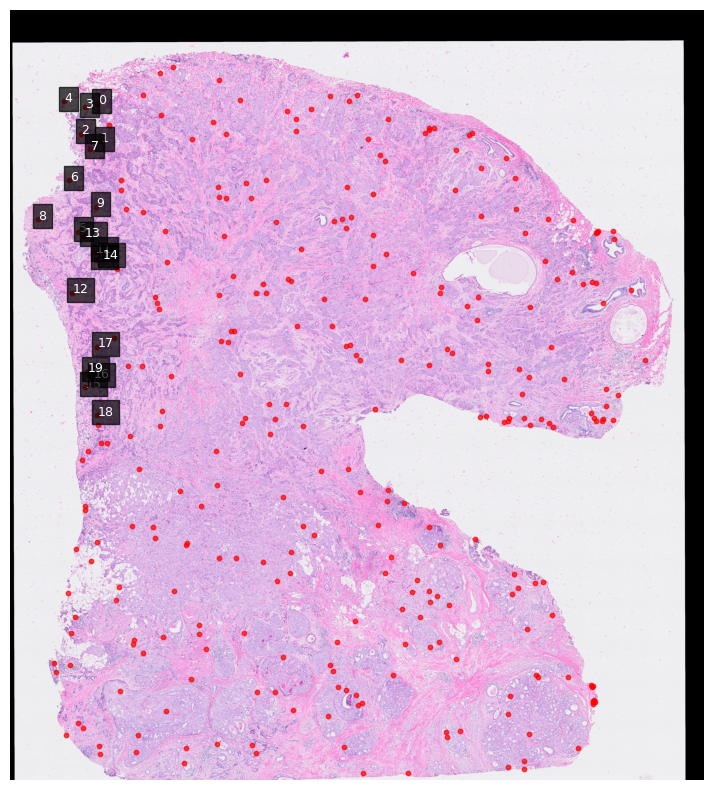

→ Extracting patches for sampled cells …
[DEBUG] Entering extract_image_patches: image shape=(53738,48376), num_points=50, P=224, kappas=[0.5, 0.75, 1.0, 1.5, 2.0]
[DEBUG] Point 0: rounded coords → (xi, yi)=(6083, 6535)
[DEBUG]  κ=0.5: crop_size=448, half=224
[DEBUG]  crop bounds for κ=0.5: x[5859:6307], y[6311:6759]
[DEBUG]  cropped shape for κ=0.5: (448, 448, 3)
[DEBUG]  resized patch shape for κ=0.5: (224, 224, 3)
[DEBUG]  κ=0.75: crop_size=299, half=149
[DEBUG]  crop bounds for κ=0.75: x[5934:6232], y[6386:6684]
[DEBUG]  cropped shape for κ=0.75: (298, 298, 3)
[DEBUG]  padding needed for κ=0.75: pad_h=1, pad_w=1, top=0, bottom=1, left=0, right=1
[DEBUG]  padded shape for κ=0.75: (299, 299, 3)
[DEBUG]  resized patch shape for κ=0.75: (224, 224, 3)
[DEBUG]  κ=1.0: crop_size=224, half=112
[DEBUG]  crop bounds for κ=1.0: x[5971:6195], y[6423:6647]
[DEBUG]  cropped shape for κ=1.0: (224, 224, 3)
[DEBUG]  resized patch shape for κ=1.0: (224, 224, 3)
[DEBUG]  κ=1.5: crop_size=150, half=75

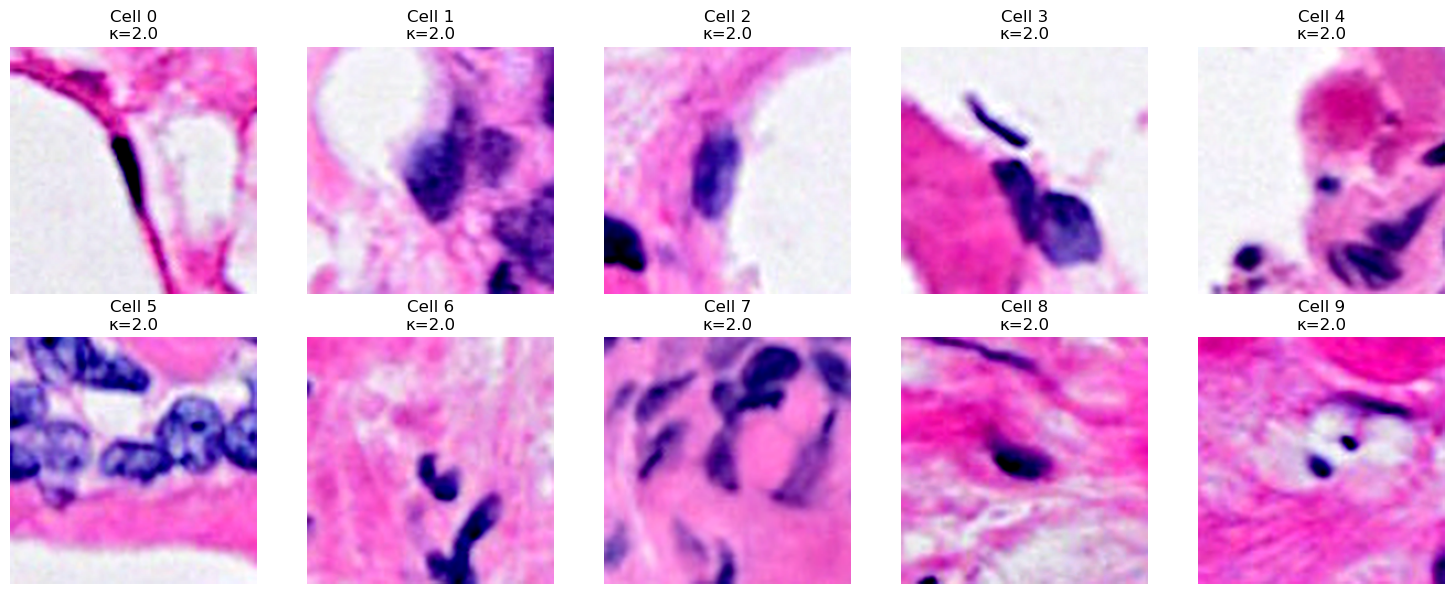


Total processing time: 32.0s


In [6]:
"""
COMPREHENSIVE ANNOTATION:
Cell Patch Extraction Pipeline for Xenium Spatial Transcriptomics Data

This code performs extraction and quality assessment of cell patches from H&E (Hematoxylin and Eosin) 
stained histology images, aligned with spatial transcriptomics data from the Xenium platform. 
The goal is to extract image patches centered around cell nuclei detected in Xenium data.

Key functionalities:
1. Loading spatial transcriptomics data and corresponding H&E images
2. Converting nucleus coordinates from microns to pixels
3. Sampling cells in a spatially distributed manner
4. Extracting image patches at multiple zoom levels (kappa values)
5. Evaluating the quality of extracted patches
6. Selecting the best patches based on quality metrics

The pipeline serves as a preprocessing step for downstream analysis that combines 
histological features with gene expression data at single-cell resolution.
"""

import os
import time
import random
import xml.etree.ElementTree as ET  # For parsing XML metadata in OME-TIFF files

# Numerical and data processing libraries
import numpy as np  # For efficient numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For visualization

# Image processing libraries
from scipy import ndimage  # For image transformations like distance transforms
from skimage import exposure, filters, measure, color, transform  # For advanced image processing
from tifffile import TiffFile  # For reading TIFF files with metadata
import spatialdata as sd  # Library for spatial transcriptomics data

from tqdm.notebook import tqdm  # Progress bar for Jupyter notebooks

# =============================================================================
# Module-level cache for heavy data
# =============================================================================
# Why use module-level caching? 
# Answer: Loading large spatial datasets and high-resolution images is computationally expensive.
# Caching these objects prevents redundant loading operations, significantly improving performance
# when functions are called multiple times.
# _cached_sdata = None  # Cache for SpatialData object
# _cached_he_image = None  # Cache for H&E image
# _cached_pixel_size = None  # Cache for pixel size (psx, psy) in microns

# Paths to data files
# Why hardcode paths?
# Answer: While not ideal for production, hardcoding simplifies development and testing.
# In a production environment, these would be parameterized or loaded from configuration.
base_dir      = "/Users/jianzhouyao/Cancer"
xenium_dir    = os.path.join(base_dir, "FFPE Human Breast with Pre-designed Panel")
zarr_path     = os.path.join(xenium_dir, "Xenium_V1_FFPE_Human_Breast_IDC_outs.zarr")
he_image_path = os.path.join(xenium_dir, "Xenium_V1_FFPE_Human_Breast_IDC_he_image.ome.tif")

# =============================================================================
# Data loading with caching
# =============================================================================
def load_data():
    """
    Load SpatialData and H&E image (with OME metadata) once and cache globally.
    
    Why use this function pattern?
    Answer: It implements a lazy loading pattern with caching. Data is loaded only when needed
    and stored for future use, preventing redundant loading operations.
    
    Returns:
        sdata: SpatialData object containing spatial transcriptomics data
        he_image: H&E image as ndarray (Height, Width, Channels)
        psx, psy: pixel size in microns (physical dimensions of each pixel)
    """
    global _cached_sdata, _cached_he_image, _cached_pixel_size
    _cached_sdata = globals().get("_cached_sdata", None)
    _cached_he_image = globals().get("_cached_he_image", None)
    _cached_pixel_size = globals().get("_cached_pixel_size", None)
    
    # Load SpatialData if not already cached
    if _cached_sdata is None:
        print("→ Loading SpatialData Zarr …")
        _cached_sdata = sd.read_zarr(zarr_path)  # Load data from Zarr storage format
        print("✔ SpatialData loaded.")
    else:
        print("← Reusing cached SpatialData.")

    # Load H&E image and metadata if not already cached
    if _cached_he_image is None or _cached_pixel_size is None:
        print("→ Loading H&E TIFF (memmap) & reading OME metadata …")
        
        # Why use memmap?
        # Answer: Memory mapping allows files to be accessed without loading the entire file into
        # memory, which is crucial for large image files that might exceed available RAM.
        with TiffFile(he_image_path) as tif:
            img = tif.asarray(out='memmap')  # Load image as memory-mapped array
            ome_xml = tif.ome_metadata  # Extract OME metadata
        
        # Why check and potentially transpose the image?
        # Answer: Standardizes the image dimensions to have channels as the last dimension (H,W,C),
        # regardless of how they were stored in the TIFF file (which might be C,H,W).
        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = np.moveaxis(img, 0, -1)  # Convert from (C,H,W) to (H,W,C) format
        
        # Parse OME-XML metadata to extract pixel size information
        # Why use ElementTree and namespaces?
        # Answer: OME-TIFF follows a standardized XML schema with specific namespaces.
        # Using ElementTree with appropriate namespaces ensures correct parsing.
        root = ET.fromstring(ome_xml)
        ns = {'ns': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}
        pixels = root.find('.//ns:Pixels', ns)
        
        # Extract physical pixel size in microns
        # Why default to 1.0?
        # Answer: Ensures the code doesn't fail if the metadata is missing.
        # A value of 1.0 implies 1 pixel = 1 micron as a fallback.
        psx = float(pixels.attrib.get('PhysicalSizeX', 1.0))
        psy = float(pixels.attrib.get('PhysicalSizeY', 1.0))
        
        # Store loaded data in cache
        _cached_he_image = img
        _cached_pixel_size = (psx, psy)
        
        print(f"✔ H&E loaded (shape={img.shape}), pixel sizes: X={psx} µm, Y={psy} µm")
    else:
        print("← Reusing cached H&E image and pixel sizes.")
        img = _cached_he_image
        psx, psy = _cached_pixel_size

    return _cached_sdata, img, psx, psy

def extract_image_patches(he_image, transformed_coords,
                          P=224,
                          kappas=[0.5, 0.75, 1.0, 1.5, 2.0],
                          resample_order=3):
    """
    Extract 224×224 patches at zoom levels κ around each point, with detailed debug prints.
    """
    H, W = he_image.shape[:2]
    print(f"[DEBUG] Entering extract_image_patches: image shape=({H},{W}), "
          f"num_points={len(transformed_coords)}, P={P}, kappas={kappas}")
    
    patches = {}

    for i, (x, y) in enumerate(transformed_coords):
        xi, yi = int(round(x)), int(round(y))
        print(f"[DEBUG] Point {i}: rounded coords → (xi, yi)=({xi}, {yi})")
        
        # skip out‐of‐bounds
        if not (0 <= xi < W and 0 <= yi < H):
            print(f"[DEBUG] Point {i} is outside image bounds; skipping.")
            continue

        patches[i] = []
        for κ in kappas:
            # compute raw patch size to crop
            crop_size = int(np.ceil(P / κ))
            half = crop_size // 2
            print(f"[DEBUG]  κ={κ}: crop_size={crop_size}, half={half}")

            x0 = max(0, xi - half)
            y0 = max(0, yi - half)
            x1 = min(W, xi + half)
            y1 = min(H, yi + half)
            print(f"[DEBUG]  crop bounds for κ={κ}: x[{x0}:{x1}], y[{y0}:{y1}]")

            # crop
            crop = he_image[y0:y1, x0:x1]
            print(f"[DEBUG]  cropped shape for κ={κ}: {crop.shape}")

            # pad if needed
            pad_h = crop_size - crop.shape[0]
            pad_w = crop_size - crop.shape[1]
            if pad_h > 0 or pad_w > 0:
                pad_top = max(0, half - yi)
                pad_left = max(0, half - xi)
                pad_bot = pad_h - pad_top
                pad_right = pad_w - pad_left
                print(f"[DEBUG]  padding needed for κ={κ}: "
                      f"pad_h={pad_h}, pad_w={pad_w}, "
                      f"top={pad_top}, bottom={pad_bot}, left={pad_left}, right={pad_right}")
                crop = np.pad(crop,
                              ((pad_top, pad_bot),
                               (pad_left, pad_right),
                               (0, 0)),
                              mode='constant',
                              constant_values=0)
                print(f"[DEBUG]  padded shape for κ={κ}: {crop.shape}")

            # resize back to P×P
            patch = transform.resize(
                crop,
                (P, P),
                order=resample_order,
                preserve_range=True
            ).astype(he_image.dtype)
            print(f"[DEBUG]  resized patch shape for κ={κ}: {patch.shape}")

            patches[i].append(patch)

        print(f"[DEBUG] Extracted {len(patches[i])} patches for point {i}")

    print(f"[DEBUG] Exiting extract_image_patches: total valid points = {len(patches)}")
    return patches

# -----------------------------------------------------------------------------
# QC & preprocessing functions
# -----------------------------------------------------------------------------
def paper_specific_qc(patches, qr):
    """
    Apply additional quality control specific to paper requirements.
    
    Why add paper-specific QC?
    Answer: This addresses issues specific to the analysis pipeline or publication
    requirements that weren't covered by the general QC. In this case, it removes
    completely black patches at the largest zoom level.
    
    Parameters:
        patches: Dictionary of patches per cell
        qr: Quality results
        
    Returns:
        Updated patches and quality results
    """
    # Identify completely black patches at kappa=2.0
    to_rm = []
    for cid in patches:
        for i,q in enumerate(qr[cid]):
            if q['kappa']==2.0 and patches[cid][i].mean()<5:
                to_rm.append((cid,i))
    
    print(f"Removing {len(to_rm)} completely black κ=2.0 patches")
    
    # Mark identified patches as invalid
    for cid,i in to_rm:
        qr[cid][i]['is_valid']=False
        qr[cid][i]['reason']="Completely black patch"
    
    return patches, qr

def mad_filter_cells(sdata, column="total_counts", verbose=True):
    """
    Filter cells based on MAD (Median Absolute Deviation) of a given column.
    
    Parameters:
        sdata: SpatialData object
        column: Column name in sdata.table.obs to apply MAD filtering on
        verbose: Whether to print status messages
    
    Returns:
        valid_cell_ids: Numpy array of filtered cell IDs
        threshold: Threshold value used for filtering
    """
    if verbose:
        print("→ Applying MAD-based filtering on", column)

    # Extract AnnData table
    cell_table = sdata.table if hasattr(sdata, 'table') else sdata['table']

    if column not in cell_table.obs.columns:
        raise ValueError(f"Missing '{column}' column in SpatialData table.")

    counts = cell_table.obs[column].values
    median_C = np.median(counts)
    mad_C = np.median(np.abs(counts - median_C))
    threshold = median_C - mad_C
    keep_mask = counts >= threshold

    valid_cell_table = cell_table[keep_mask]
    valid_cell_ids = valid_cell_table.obs_names.to_numpy()

    n_valid = keep_mask.sum()
    if n_valid == 0:
        raise ValueError("No cells passed MAD filtering. Consider adjusting the threshold.")

    if verbose:
        print(f"✔ {n_valid} cells kept (≥ {threshold:.1f} {column})")
    print(f"✔ {n_valid} cells kept (≥ {threshold:.1f} transcripts)")
    return valid_cell_ids, threshold

def extract_xenium_nucleus_centroids_from_spatialdata(sdata):
    """
    Extract nucleus centroids from a SpatialData object containing Xenium data.
    """
    print("[DEBUG] Entering extract_xenium_nucleus_centroids_from_spatialdata")
    print(f"[DEBUG] Available shape keys: {list(sdata.shapes.keys())}")

    # Try to get nucleus boundaries or cell circles to extract centroids
    if 'nucleus_boundaries' in sdata.shapes:
        print("[DEBUG] Using 'nucleus_boundaries' from sdata.shapes")
        nucleus_shapes = sdata.shapes['nucleus_boundaries']
        print(f"[DEBUG] nucleus_shapes contains {len(nucleus_shapes)} geometries")
        nucleus_centroids = np.array([
            (geom.centroid.x, geom.centroid.y) 
            for geom in nucleus_shapes.geometry
        ])
        cell_ids = nucleus_shapes.index.values
        print(f"[DEBUG] Extracted {nucleus_centroids.shape[0]} nucleus centroids")

    elif 'cell_circles' in sdata.shapes:
        print("[DEBUG] Using 'cell_circles' from sdata.shapes")
        cell_circles = sdata.shapes['cell_circles']
        print(f"[DEBUG] cell_circles contains {len(cell_circles)} geometries")
        nucleus_centroids = np.array([
            (geom.centroid.x, geom.centroid.y) 
            for geom in cell_circles.geometry
        ])
        cell_ids = cell_circles.index.values
        print(f"[DEBUG] Extracted {nucleus_centroids.shape[0]} cell circle centroids as nucleus centroids")

    else:
        print("[DEBUG] Neither 'nucleus_boundaries' nor 'cell_circles' found. Trying 'spatial' in obsm...")
        if 'spatial' in sdata.tables['table'].obsm:
            nucleus_centroids = sdata.tables['table'].obsm['spatial']
            cell_ids = sdata.tables['table'].obs_names.values
            print(f"[DEBUG] Extracted {nucleus_centroids.shape[0]} centroids from obsm['spatial']")
        else:
            raise ValueError("Could not find nucleus centroids in the SpatialData object")

    print("[DEBUG] Exiting extract_xenium_nucleus_centroids_from_spatialdata")
    return nucleus_centroids, cell_ids


def normalize_patch(patch):
    """
    Normalize image patch using ImageNet mean and standard deviation.
    
    Why use ImageNet normalization?
    Answer: These values standardize images to work well with deep learning models
    pretrained on ImageNet, which is a common practice in transfer learning. It helps
    models generalize better across different image sources.
    
    Parameters:
        patch: Image patch to normalize
        
    Returns:
        norm: Normalized patch (floating point, for model input)
        vis: Visualization of normalized patch (uint8, for display)
    """
    # Convert to float32 if needed and scale to [0,1]
    pf = patch.astype(np.float32)/255.0 if patch.dtype!=np.float32 else patch.copy()
    
    # ImageNet mean and standard deviation per channel
    means = [0.485, 0.456, 0.406]  # RGB means from ImageNet
    stds  = [0.229, 0.224, 0.225]  # RGB standard deviations from ImageNet
    
    # Apply normalization: (x - mean) / std
    norm = np.zeros_like(pf)
    for i,(m,s) in enumerate(zip(means,stds)):
        norm[:,:,i] = (pf[:,:,i]-m)/s

    # Normalize  the mean and standard deviation to 0 and 1
    # Why normalize to 0 and 1?
    # Answer: This is a common preprocessing step for deep learning models,
    # ensuring that the input data has a consistent scale and distribution.
    # This helps the model learn more effectively and reduces sensitivity to
    # input variations.
    
    # Create visualization by reversing normalization
    # Why create visualization?
    # Answer: The normalized image values are not in displayable range.
    # This creates a version that can be visualized to verify normalization.
    vis = np.zeros_like(patch)
    for i,(m,s) in enumerate(zip(means,stds)):
        vis[:,:,i] = np.clip((norm[:,:,i]*s + m)*255, 0, 255).astype(np.uint8)
    
    return norm, vis

def extract_image_patches_enhanced(he_image, coords, P=224, kappas=[0.5,0.75,1.0,1.5,2.0]):
    """
    Extract and enhance image patches at multiple zoom levels (kappas).
    
    Why extract at multiple zoom levels?
    Answer: Different zoom levels capture different biological contexts:
    - Low kappa (high zoom): Details of individual cell
    - High kappa (low zoom): Cell's neighborhood and tissue context
    This multi-scale approach provides complementary information.
    
    Parameters:
        he_image: Full H&E image
        coords: Pixel coordinates of cell centers
        P: Patch size in pixels
        kappas: Zoom levels (smaller values = more zoomed in)
        
    Returns:
        enh: Enhanced patches (contrast-adjusted)
        normed: Normalized patches (for model input)
    """
    # Extract raw patches using external function
    raw = extract_image_patches(he_image, coords, P, kappas)
    
    enh, normed = {}, {}
    for cid in raw:
        enh[cid] = []
        normed[cid] = []
        for patch in raw[cid]:
            # Skip enhancement for black patches (likely outside image bounds)
            if patch.mean() < 5:
                enh[cid].append(patch)
                normed[cid].append(None)
            else:
                # Apply contrast enhancement using percentile-based rescaling
                # Why use 2nd and 98th percentiles?
                # Answer: This robust range excludes extreme outliers while enhancing
                # the majority of relevant image content, improving the visibility
                # of cellular structures.
                p2,p98 = np.percentile(patch, (2,98))
                ce = exposure.rescale_intensity(patch, in_range=(p2,p98))
                
                # Apply ImageNet normalization
                n, v = normalize_patch(ce)
                enh[cid].append(v)
                normed[cid].append(n)
    return enh, normed

def sample_grid_cells(centroids, grid_size=8, cells_per_grid=5):
    """
    Sample cells from a spatial grid for balanced representation.
    
    Why use grid sampling?
    Answer: Random sampling might oversample dense regions and undersample sparse ones. -> some regions may have many detected cells (high density), while others are sparse
    If you randomly sample cells, you'll likely pick many from dense regions and miss spatially interesting areas.
    Grid sampling samples cells evenly across space using a grid.
    
    Parameters:
        centroids: Array of (x,y) coordinates
        grid_size: Number of grid divisions in each dimension -> Default = 8 → 8×8 = 64 grid cells.
        cells_per_grid: Maximum cells to sample from each grid cell -> Default = 5
        
    Returns:
        Array of indices of sampled cells
    """
    xs, ys = centroids[:,0], centroids[:,1]
    xmin,xmax, ymin,ymax = xs.min(), xs.max(), ys.min(), ys.max()
    
    # Calculate grid cell sizes
    dx, dy = (xmax-xmin)/grid_size, (ymax-ymin)/grid_size
    
    out = []
    # Iterate through each grid cell
    for i in range(grid_size):
        for j in range(grid_size):
            # Find cells within current grid cell
            m = ((xs>=xmin+i*dx)&(xs<xmin+(i+1)*dx)&
                 (ys>=ymin+j*dy)&(ys<ymin+(j+1)*dy))
            idx = np.where(m)[0]
            
            # Sample cells from current grid cell
            if idx.size:
                take = min(cells_per_grid, idx.size)
                out.extend(np.random.choice(idx, take, replace=False))
    
    return np.array(out)





def visualize_quality_distribution(qr):
    """
    Create histograms and boxplots of patch quality scores.
    
    Why visualize quality distribution?
    Answer: Visual inspection of quality scores helps identify patterns and potential issues:
    - Overall distribution shows if quality assessment is working properly
    - Per-kappa boxplots reveal which zoom levels yield better patches
    
    Parameters:
        qr: Quality results dictionary
    """
    # Collect scores overall and by kappa
    scores = []
    byk = {k:[] for k in [0.5,0.75,1.0,1.5,2.0]}
    for cid in qr:
        for q in qr[cid]:
            scores.append(q['score'])
            byk[q['kappa']].append(q['score'])
    
    # Create visualization with histogram and boxplot
    plt.figure(figsize=(12,5))
    
    # Overall score histogram
    plt.subplot(1,2,1)
    plt.hist(scores,bins=20)
    plt.axvline(0.5, color='r', linestyle='--')  # Quality threshold line
    plt.title("Overall QC score")
    
    # Boxplot by kappa value
    plt.subplot(1,2,2)
    plt.boxplot([byk[k] for k in [0.5,0.75,1.0,1.5,2.0]],
                labels=['0.5','0.75','1.0','1.5','2.0'])
    plt.title("By κ")
    
    plt.tight_layout()
    plt.show()

def create_figure_like_paper(patches, qr, n_cells=5):
    """
    Create a figure showing multiple zoom levels for top-quality cells.
    
    Why create a paper-like figure?
    Answer: Creates a standardized visualization for publication or presentation
    that demonstrates the multi-scale approach used in the analysis.
    
    Parameters:
        patches: Dictionary of patches per cell
        qr: Quality results
        n_cells: Number of cells to display
        
    Returns:
        List of selected cell IDs
    """
    # Select cells where all kappa values produced valid patches
    cells = []
    for cid in patches:
        if all(q['is_valid'] for q in qr[cid]):
            cells.append((cid, np.mean([q['score'] for q in qr[cid]])))
    
    # Sort by average quality score
    cells.sort(key=lambda x: x[1], reverse=True)
    sel = [cid for cid,_ in cells[:n_cells]]
    
    # Create visualization
    fig, axes = plt.subplots(n_cells, 5, figsize=(15,3*n_cells))
    for r,cid in enumerate(sel):
        for c in range(5):
            axes[r,c].imshow(patches[cid][c])
            axes[r,c].axis('off')
            axes[r,c].set_title(f"κ={[0.5,0.75,1.0,1.5,2.0][c]}")
    
    plt.suptitle("Top cells at all zooms")
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()
    
    return sel


# =============================================================================
# Fast downsample preview via strided slicing
# =============================================================================
def create_downsampled_preview(he_image, coords_px, sample_indices, factor=10):
    """
    Create a downsampled preview of the H&E image with sampled cell locations.
    
    Why create a downsampled preview?
    Answer: Full-resolution H&E images can be extremely large (gigapixels). A downsampled
    preview allows quick visual verification of coordinate mapping and sampling without
    requiring excessive memory or computation.
    
    Parameters:
        he_image: Full H&E image
        coords_px: Pixel coordinates of all cells
        sample_indices: Indices of sampled cells
        factor: Downsampling factor
    """
    h, w = he_image.shape[:2]
    small_h, small_w = h // factor, w // factor
    print(f"→ Fast downsample to ({small_h}, {small_w}) via slicing …")
    
    # Downsample image via strided slicing
    # Why use slicing instead of interpolation?
    # Answer: Much faster for large images, and sufficient for preview purposes
    small_image = he_image[::factor, ::factor, :].astype(np.uint8)
    
    # Scale down coordinates to match downsampled image
    pts = coords_px[sample_indices] // factor
    x_pts, y_pts = pts[:, 0], pts[:, 1]
    
    # Visualize sampled points on downsampled image
    plt.figure(figsize=(8, 8))
    plt.imshow(small_image)
    plt.scatter(x_pts, y_pts, c='red', s=10, alpha=0.7)
    
    # Label first 20 points for reference
    for i, idx in enumerate(sample_indices[:20]):
        x, y = coords_px[idx] // factor
        plt.text(x + 5, y + 5, str(i), color='white', fontsize=9,
                 bbox=dict(facecolor='black', alpha=0.7))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    

# =============================================================================
# Main pipeline with optional preloading
# =============================================================================
def main_patch_extraction_pipeline(sdata=None, he_image=None, psx=None, psy=None):
    """
    Main function that orchestrates the entire patch extraction pipeline.
    
    Why have a comprehensive pipeline function?
    Answer: Organizes the entire workflow in a logical sequence, making it easier to:
    1. Understand the complete process
    2. Identify bottlenecks
    3. Reuse the pipeline with different datasets
    4. Optionally skip steps by providing preloaded data
    
    Parameters:
        sdata: Optional preloaded SpatialData object
        he_image: Optional preloaded H&E image
        psx, psy: Optional preloaded pixel sizes
        
    Returns:
        Dictionary containing all extracted data and results
    """
    t_start = time.time()
    print("[DEBUG] Starting patch extraction pipeline\n")
    
    # Load data if not provided
    if sdata is None or he_image is None or psx is None or psy is None:
        sdata, he_image, psx, psy = load_data()
    else:
        print("← Using provided SpatialData and H&E image, skipping load_data.")
    
    # ------------------------------------------------------------------------
    # Step 1: Filter cells based on total counts using MAD
    # ------------------------------------------------------------------------
    print("→ Filtering cells based on total counts using MAD …")
    valid_cell_ids, threshold = mad_filter_cells(sdata)

    # ------------------------------------------------------------------------
    # Step 2: Extract centroids of valid cells from SpatialData geometry
    # ------------------------------------------------------------------------
    print("→ Extracting centroids from SpatialData geometry …")

    # Use helper function to get all centroids
    all_centroids_um, all_cell_ids = extract_xenium_nucleus_centroids_from_spatialdata(sdata)

    # Print debug information about cell ID formats 
    print(f"→ Debug: First few valid_cell_ids: {valid_cell_ids[:3]}")
    print(f"→ Debug: First few all_cell_ids: {all_cell_ids[:3]}")
    print(f"→ Debug: Types - valid_cell_ids: {type(valid_cell_ids[0])}, all_cell_ids: {type(all_cell_ids[0])}")

    # Ensure consistent ID format (convert both to strings)
    valid_cell_ids_set = set(str(cid) for cid in valid_cell_ids)
    all_cell_ids_str = np.array([str(cid) for cid in all_cell_ids])

    # Filter centroids to match valid cell IDs
    keep_mask = np.array([cid in valid_cell_ids_set for cid in all_cell_ids_str])
    centroids_um = all_centroids_um[keep_mask]
    cell_ids = np.array([all_cell_ids[i] for i in np.where(keep_mask)[0]])

    # Check if we have matching cells
    if len(centroids_um) == 0:
        raise ValueError("No cells matched between filtered AnnData and nucleus boundaries. Check cell ID formats.")

    print(f"✔ Extracted {len(centroids_um)} valid centroids after MAD filtering\n")
    
    # Convert physical coordinates (microns) to pixel coordinates
    print("→ Converting centroids from µm → pixels …")
    coords_px = np.zeros_like(centroids_um, dtype=int)
    coords_px[:, 0] = np.round(centroids_um[:, 0] / psx).astype(int)
    coords_px[:, 1] = np.round(centroids_um[:, 1] / psy).astype(int)
    print("✔ Sample pixel coords:", coords_px[:5], "\n")
    
    # Clip coordinates to image boundaries
    # Why clip coordinates?
    # Answer: Prevents out-of-bounds errors when extracting patches.
    # Some cells might be detected slightly outside the imaged area.
    h, w = he_image.shape[:2]
    coords_px[:, 0] = np.clip(coords_px[:, 0], 0, w - 1)
    coords_px[:, 1] = np.clip(coords_px[:, 1], 0, h - 1)
    
    # Sample cells using grid-based approach
    # Why sample instead of using all cells?
    # Answer: Processing all cells would be computationally expensive and unnecessary
    # for quality assessment or method development. Grid sampling ensures spatial
    # diversity while keeping the sample size manageable.
    sample_idx = sample_grid_cells(coords_px, grid_size=8, cells_per_grid=5)
    print(f"→ Sampled {len(sample_idx)} cells\n")
    
    # Create visual preview of sampled cells
    create_downsampled_preview(he_image, coords_px, sample_idx)
    
    # Extract patches only for sampled cells and assess quality
    # Extract and enhance patches without quality assessment
    print("→ Extracting patches for sampled cells …")
    test_idxs = sample_idx[:min(50, len(sample_idx))]  # Limit for testing/visualization
    enhanced_patches, normalized_patches = extract_image_patches_enhanced(
        he_image, coords_px[test_idxs]
    )

    # Create dummy quality results: all valid initially
    quality_results = {}
    kappas = [0.5, 0.75, 1.0, 1.5, 2.0]
    for cid in enhanced_patches:
        quality_results[cid] = [
            {'kappa': k, 'score': 1.0, 'is_valid': True, 'reason': 'Valid'}
            for k in kappas
        ]

    # Apply black-patch QC at kappa=2.0 only
    final_patches, final_quality = paper_specific_qc(enhanced_patches, quality_results)

    # Skip QC summary, distribution plots, etc.

    # (Optional) Just show a few patches without filtering by score
    print(f"✔ Extracted patches for {len(final_patches)} cells\n")
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i, (cid, patches_list) in enumerate(list(final_patches.items())[:10]):
        patch = patches_list[-1]  # Show κ=2.0 as an example
        axes[i].imshow(patch)
        axes[i].axis('off')
        axes[i].set_title(f"Cell {cid}\nκ=2.0")
    plt.tight_layout()
    plt.show()

    
    # Calculate and display total processing time
    print(f"\nTotal processing time: {time.time() - t_start:.1f}s")
    
    # Return all extracted data for potential downstream use
    # Why return a comprehensive dictionary?
    # Answer: Allows flexibility for different downstream analyses,
    # debugging, or further processing without rerunning the entire pipeline.
    return {
        'centroids_px': coords_px,
        'cell_ids': cell_ids,
        'sample_indices': sample_idx,
        'enhanced_patches': final_patches,
        'normalized_patches': normalized_patches,
        'quality_results': final_quality,
    }

if __name__ == '__main__':
    # Optionally preload data once
    sdata_cache, he_image_cache, psx_cache, psy_cache = load_data()
    # Then reuse caches on subsequent calls
    results = main_patch_extraction_pipeline(
        sdata=sdata_cache,
        he_image=he_image_cache,
        psx=psx_cache,
        psy=psy_cache
    )